In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
# import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
# from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
# from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
# from tensorflow.python.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.python.keras.models import Model, load_model
# from tensorflow.python.keras.utils import multi_gpu_model, plot_model ,Sequence
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp
import os
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

In [2]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model
model1 = Unet(224 , 224 , 34)
model1.load_weights('../input/background-removal/top-weights.h5')

model2 = Unet(224 , 224 , 34)
model2.load_weights('../input/smooth-blobs/model.h3')

In [3]:
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()
	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()
	# run selective search on the input image
	rects = ss.process()
	# return the region proposal bounding boxes
	return rects

In [4]:
im_size = 2500
from keras.models import Model
from keras.layers import Input,Lambda,merge
from keras.layers import Conv2D,Cropping2D,Average
from keras.layers import MaxPooling2D
from keras.utils import plot_model
from keras import backend as K
import keras
base = Input(shape=(im_size, im_size, 3))

mask = tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(base)

rmodel = Unet(224 , 224 , 34)
rmodel.load_weights('../input/background-removal/top-weights.h5')
rmodel.trainable=False
mask = rmodel(mask)
mask = tf.keras.layers.experimental.preprocessing.Resizing(im_size, im_size, interpolation="bilinear")(mask)
    
mask = Lambda(lambda w:  K.round(w))(mask)  
x = keras.layers.Multiply()([base, mask])  

model = Model(base,x)

In [5]:
import pickle
xmodel = pickle.load(open("../input/classification-with-keras/XGBmodel.sav","rb"))

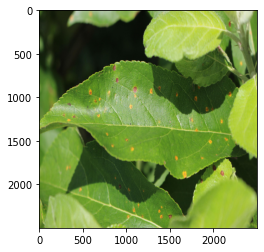

In [6]:
id = os.listdir("../input/plant-pathology-2021-fgvc8/train_images")[-420]#-1365
i = "../input/plant-pathology-2021-fgvc8/train_images/"+id

original_img = img_to_array(load_img(i,target_size=(im_size,im_size,3)))
plt.imshow(original_img/255)

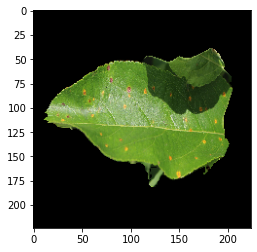

In [7]:
img = original_img.copy()
img = np.expand_dims(img,axis=0)/255.
img = model.predict(img)
img0 = cv2.resize(img[0], (224, 224))

plt.imshow(img0)



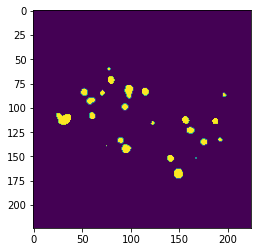

In [8]:
img0 = np.expand_dims(img0,axis=0)
mask0 = model2.predict(img0)[0]
img = img[0]
H,W,_= img.shape
# plt.imshow(mask0)
mask = mask0.copy()
mask[np.where((mask>0.5).all(axis=2))] = 255;
mask[np.where((mask<0.5).all(axis=2))] = 0;
inter = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
inter = cv2.cvtColor(inter,cv2.COLOR_BGR2GRAY)
inter = inter.astype(np.uint8)
plt.imshow(inter)

rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust
rust


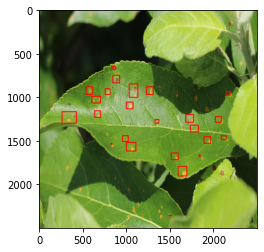

In [9]:



cnts, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



out = original_img.copy()/255
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    mask_resized = cv2.resize(np.uint8(mask0*255),(W,H))
    mask_resized = mask_resized != 0
    a,b = W//224,H//224
    x,y,w,h = int(x*a),int(y*b),int(w*a),int(h*b)
    roi = img[y:y + h, x:x + w]
    roi = cv2.resize(roi,(20,20))
    xx = np.array(roi).reshape(1,3*20*20)
    color = 2
    cv2.rectangle(out, (x, y), (x+w, y+h), (1,0,0), 10)
    label = xmodel.predict(xx)[0]
    print(label)
#     cv2.putText(out, label, (x, y-int(h/10)),
# 			cv2.FONT_HERSHEY_SIMPLEX, 3, (1,0,0), 10)
    

plt.imshow(out)